### FashionMNIST dataset - Image classification using CNN

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets   #to impot FashionMNist images
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm   # for progress bar
from timeit import default_timer as timer 
import random

print(torch.__version__)
print(torchvision.__version__)

2.2.2
0.17.2


FashionMNIST from torchvision.datasets

https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST

In [3]:
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # do we want the training dataset?
    download=True, # do we want to download yes/no?
    transform=ToTensor(), # how do we want to transform the data?
    target_transform=None #transform the labels/targets?
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
#a sample image (the first one)
image, label = train_data[0]
image.shape, label


(torch.Size([1, 28, 28]), 9)

In [6]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
train_data.targets  #labels

tensor([9, 0, 0,  ..., 3, 0, 5])

The 3 values in image shape are `color_channels, height, width` in order.

In this dataset color_channel= 1 because images are grayscale. It would be 3 for colored images.

In [9]:
#the shape of the first image
print(f"Image shape: {image.shape}")      #color_channels (RGB), height, width
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28])
Image label: Ankle boot


We need to squeez the image shape to plot it in 2D.

image shape: torch.Size([1, 28, 28])
squeezed image shape: torch.Size([28, 28])


Text(0.5, 1.0, '9')

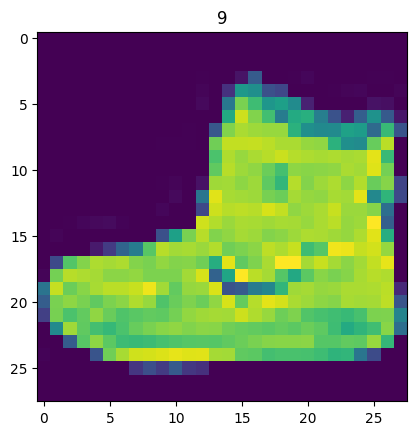

In [10]:
image, label = train_data[0]
print(f"image shape: {image.shape}")
print(f"squeezed image shape: {image.squeeze().shape}")   # Removes dimensions with size 1
plt.imshow(image.squeeze())
plt.title(label)

(-0.5, 27.5, 27.5, -0.5)

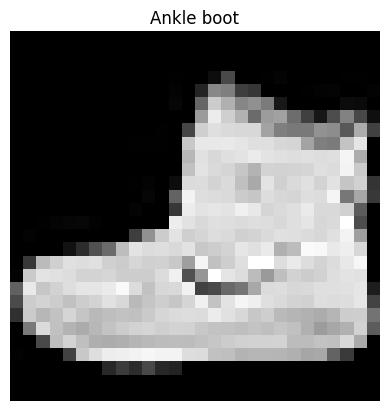

In [11]:
#change the setting of cmap in plt.imshow for gray images
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

In [12]:
print(torch.randint(0, len(train_data), size=[4]))     #tensor
print(torch.randint(0, len(train_data), size=[1]).item())  #value

tensor([23124, 51666, 46440, 52252])
56216


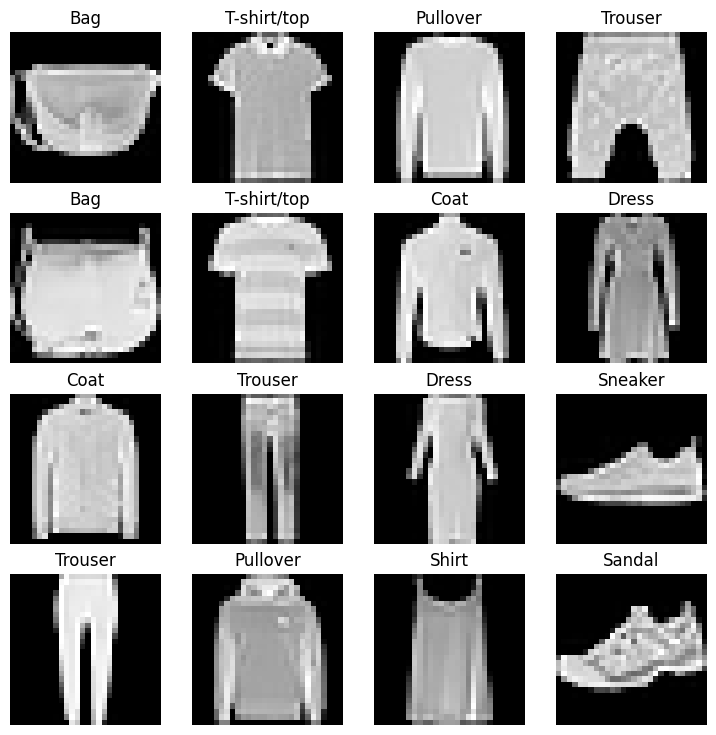

In [13]:
# torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()  
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [14]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [15]:
# create Dataloader

BATCH_SIZE = 32
# turns our dataset which is in the form of PyTorch Datasets into a Python iterable (batches)
train_dataloader = DataLoader(dataset= train_data,
                              batch_size= BATCH_SIZE,
                              shuffle= True)

test_dataloader = DataLoader(dataset= test_data,
                             batch_size= BATCH_SIZE,
                             shuffle= False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f9853abbbe0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f9853abb5e0>)

In [16]:
#the length of dataloaders
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f9853abbbe0>, <torch.utils.data.dataloader.DataLoader object at 0x7f9853abb5e0>)
Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


In [17]:
# what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))   # next gets the next item from an iterable
train_features_batch.shape, train_labels_batch.shape                      # iter turns the object to iterable

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

image shape: torch.Size([1, 28, 28])
squeezed image shape: torch.Size([28, 28])
label: 1


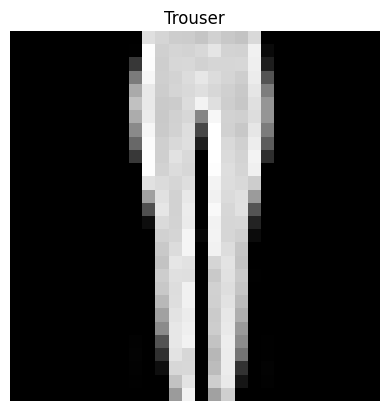

In [18]:
# an image from training batches
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"image shape: {img.shape}")
print(f"squeezed image shape: {img.squeeze().shape}")
print(f"label: {label}")

In [19]:
# cpu or gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'


The CNN model is TinyVGG architecture from the https://poloclub.github.io/cnn-explainer/.

For 2d images nn.Conv2d() (there are 1d (for text) and 3d as well): https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html



Input layer -> [Convolutional layer -> activation layer -> pooling layer] -> Output layer

Where the contents of [Convolutional layer -> activation layer -> pooling layer] can be upscaled and repeated multiple times, depending on requirements.


In [20]:
# CNN
class cnnmodel1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()         #inherit from nn.Module
        self.conv_block_1 = nn.Sequential(          
        nn.Conv2d(in_channels=input_shape,       #input layer
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),                                #activation layer                       
        nn.Conv2d(in_channels=hidden_units,       #convolutional layer
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),                                #activation layer   
        nn.MaxPool2d(kernel_size=2)               #pooling layer
        )
        self.conv_block_2 = nn.Sequential(            #convolutional layer
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),                               #activation layer  
        nn.Conv2d(in_channels=hidden_units,      #convolutional layer
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),                               #activation layer  
        nn.MaxPool2d(kernel_size=2)              #pooling layer
       )
        self.classifier = nn.Sequential(         #output layer
        nn.Flatten(),                               #flatten the output of the two blocks into a single feature vector
        nn.Linear(in_features=hidden_units*7*7,     # 10*7*7 is the output shape from conv_block2
                  out_features=output_shape)
        )
    
    def forward(self, x):
        x = self.conv_block_1(x)
        #print(f"Output shape of conv_block_1: {x.shape}")
        x = self.conv_block_2(x) 
        #print(f"Output shape of conv_block_2: {x.shape}")
        x = self.classifier(x)
        #print(f"Output shape of classifier: {x.shape}")
        return x

The in_features of classifier layer = 10 * 7 * 7. 

10,7,7 is the ouput shape of conv_block2 and the flattened version (multiplication) is the input of classifier layer, this is needed for matrix multiplication in classification layer.

The shape of all sample images is 1,28,28.

The layers of the network compress the shape and extract info from images.

If we run the model with an image of size 1,28,28 we will see this

In [21]:
#creating the model with 10 neurons for hidden layers
torch.manual_seed(42)
model1 = cnnmodel1(input_shape=1,       #if the images were colored, input_shape=3 for RGB
                   hidden_units=10, 
                   output_shape=len(class_names)).to(device)

In [22]:
rand_image_tensor = torch.randn(size=(1, 28, 28))
print(rand_image_tensor.shape)

# Pass image through model
model1(rand_image_tensor.unsqueeze(0).to(device))   #unsqueeze to add a dim for batch size

torch.Size([1, 28, 28])


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], grad_fn=<AddmmBackward0>)

In [23]:
model1.state_dict()   # adjusted weights and biases of model

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
      

In [24]:
# loss function, evaluation metric and optimizer

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


loss_fn = nn.CrossEntropyLoss()   # multiclass classification
optimizer = torch.optim.SGD(params=model1.parameters(),lr=0.1)

In [25]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    
    train_loss, train_acc = 0, 0

    # Put model into training mode
    model.train()

    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(data_loader):
        # Put data on target device 
        X, y = X.to(device), y.to(device)

        # 1. Forward pass (outputs the raw logits from the model)
        y_pred = model(X)

        # 2. Calculate loss and accuracy (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=torch.softmax(y_pred.squeeze(), dim=1).argmax(dim=1)) # go from logits -> prediction labels

        # 3. Optimizer zero grad. Sets the gradients of all optimized torch.Tensors to zero.
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step (update the model's parameters once per batch)
        optimizer.step()

    # Divide total train loss and acc by length of train dataloader (getting the average for all batches)
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [26]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    
    test_loss, test_acc = 0, 0
  
    # Put the model in eval mode
    model.eval()

    # Turn on inference mode context manager
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            # 1. Forward pass (outputs raw logits)
            test_pred = model(X)
           
            # 2. Calculuate the loss/acc
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                  y_pred=torch.softmax(test_pred.squeeze(), dim=1).argmax(dim=1)) # go from logits -> prediction labels 
            
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [27]:
print(device)

cpu


In [28]:
# a function to calculate training time

def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")

In [29]:
# Train and test the model

torch.manual_seed(42)
start_time= timer()

epochs = 5
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n")
    train_step(model=model1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
    test_step(model=model1,
            data_loader=test_dataloader,       # was better to use an evaluation dataset here
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

end_time = timer()
print_train_time(start=start_time, end=end_time,
                 device=str(next(model1.parameters()).device))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0

Train loss: 0.59856 | Train acc: 78.36%


 20%|██        | 1/5 [00:42<02:51, 42.87s/it]

Test loss: 0.38782 | Test acc: 86.14%

Epoch: 1

Train loss: 0.35811 | Train acc: 87.14%


 40%|████      | 2/5 [01:23<02:03, 41.30s/it]

Test loss: 0.35064 | Test acc: 87.06%

Epoch: 2

Train loss: 0.32150 | Train acc: 88.35%


 60%|██████    | 3/5 [02:02<01:21, 40.54s/it]

Test loss: 0.32270 | Test acc: 88.39%

Epoch: 3

Train loss: 0.29989 | Train acc: 89.14%


 80%|████████  | 4/5 [02:42<00:40, 40.12s/it]

Test loss: 0.34156 | Test acc: 87.35%

Epoch: 4

Train loss: 0.28532 | Train acc: 89.60%


100%|██████████| 5/5 [03:23<00:00, 40.66s/it]

Test loss: 0.30068 | Test acc: 89.07%

Train time on cpu: 203.351 seconds


In [30]:
# save the last model after all epoches

torch.save(model1, "cnn_model.pt")
# torch.save(model1.state_dict(), "cnn_model_weights.pth")  # to only save model parameters (not architecture)
print("Final model saved")

Final model saved


In [31]:
# load the saved model

loaded_model = torch.load("cnn_model.pt")
# loaded_model = cnnmodel1()
# loaded_model.load_state_dict(torch.load("cnn_model_weights.pth"))  
loaded_model.to(device) 

cnnmodel1(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [32]:
# model evaluation

torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, 
               accuracy_fn,
               device=device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                             y_pred=torch.softmax(y_pred.squeeze(), dim=1).argmax(dim=1))  # go from logits -> prediction labels 

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

In [33]:
# results

loaded_model_results = eval_model(
     model=loaded_model,
     data_loader=test_dataloader,
     loss_fn=loss_fn,
     accuracy_fn=accuracy_fn,
     device=device
)

loaded_model_results

100%|██████████| 313/313 [00:03<00:00, 103.29it/s]


{'model_name': 'cnnmodel1',
 'model_loss': 0.30067721009254456,
 'model_acc': 89.06749201277955}

In [35]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Forward pass (model outputs raw logits)
            pred_logit = model(sample)              #the number of logits=the number of classes for each image
            #print(pred_logit)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)     #squeeze to remove one dim of tensor of logits

            pred_probs.append(pred_prob)
            

    # turn list into a tensor
    return torch.stack(pred_probs)

In [46]:
# a sample of test data 

# random.seed(42)
test_samples = [] 
test_labels = []
for sample, label in random.sample(list(test_data), k=6):   # test_data is not a dataloader
    test_samples.append(sample)
    test_labels.append(label)

#the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

In [47]:
len(test_samples)

6

Text(0.5, 1.0, 'T-shirt/top')

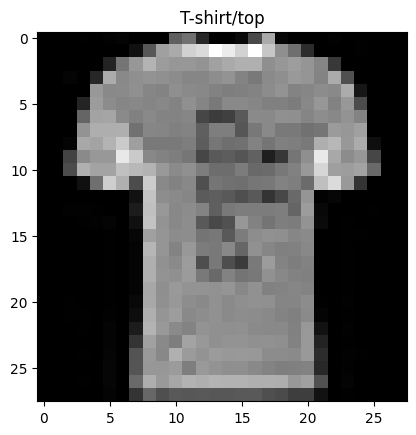

In [48]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [49]:
# make predictions

pred_probs = make_predictions(model= loaded_model,
                              data= test_samples)
#prediction probabilities 
print(pred_probs.shape)
pred_probs[:]

torch.Size([6, 10])


tensor([[9.9549e-01, 6.7789e-08, 3.9255e-05, 1.8416e-05, 1.7473e-07, 3.1893e-08,
         4.4528e-03, 4.2610e-09, 2.5493e-06, 3.3377e-09],
        [5.0443e-03, 1.2035e-03, 1.4393e-02, 1.6166e-02, 9.0423e-01, 1.0856e-05,
         5.4312e-02, 3.1588e-05, 4.5840e-03, 1.9443e-05],
        [8.5016e-06, 9.9996e-01, 1.3249e-09, 2.3176e-05, 4.4809e-06, 1.3502e-07,
         4.2545e-06, 5.3290e-08, 2.5380e-07, 5.5209e-09],
        [7.6071e-06, 9.9996e-01, 2.9840e-08, 8.6639e-06, 1.2547e-05, 4.7528e-07,
         6.4354e-06, 3.2317e-08, 1.1395e-06, 1.2168e-08],
        [2.3548e-03, 1.9774e-04, 3.3818e-01, 3.2995e-05, 5.8663e-01, 2.4429e-04,
         7.1637e-02, 3.4622e-05, 5.5528e-04, 1.3340e-04],
        [4.9085e-05, 6.7261e-07, 2.5739e-05, 6.5594e-07, 2.8202e-07, 1.0155e-02,
         2.3479e-05, 9.1415e-01, 2.7147e-04, 7.5322e-02]])

In [50]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([0, 4, 1, 1, 4, 7])

In [42]:
test_labels

[7, 2, 7, 4, 8, 3]

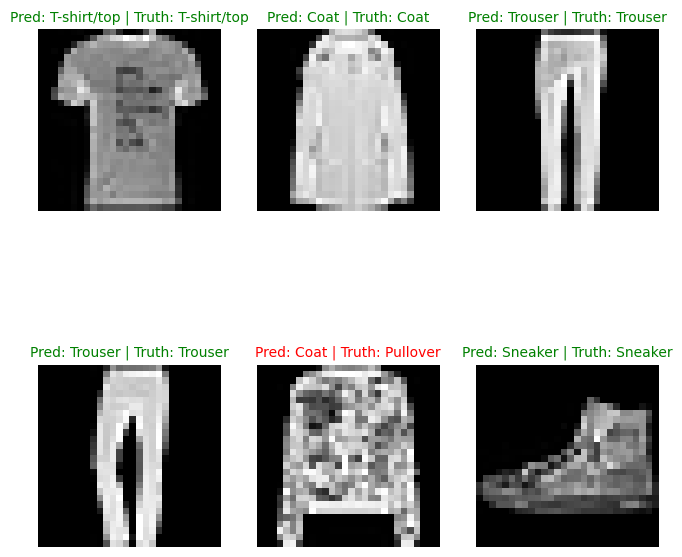

In [51]:
# plot predictions

plt.figure(figsize=(8,8))
nrows = 2
ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap="gray")
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]

    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
    else:
        plt.title(title_text, fontsize=10, c="r") 

    plt.axis(False)

A useful link : 

https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.26300&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false